In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [9]:
import prfpy_csenf
import os 
from os.path import join as opj
sfs_seq = './eg_sfs_seq.npy'
con_seq = './eg_con_seq.npy'

paradigm = np.vstack([sfs_seq, con_seq])


In [3]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [4]:
parameters = pd.DataFrame({
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  40.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amplitude'         : np.array([   1.00,   1.00,   1.00,   2.00,]), # [fMRI parameters]
    'baseline'          : np.array([   0.00,   0.00,   1.00,   0.00,]), # 
    }).astype('float32')



In [5]:
from prfpy_csenf.stimulus import CSenFStimulus
from prfpy_csenf.model import CSenFModel

from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel

# Witout HRF

In [12]:
SF_levels = [ 0.5,  1.,   3.,   6.,  12.,  18. ] 
# SF_levels = np.linspace(0.5, 18, 18)
def create_sequence(n_c_steps, n_c_rep, **kwargs):
    # we want blank down-SF1, up-SF2, blank, ...
    SF_list = [3, 18, 1, 6, 0.5, 12, 6, 1, 12, 3, 18, 0.5] # pseudo random...
    con_list = np.repeat(
        # np.logspace(np.log10(0.25), np.log10(80), n_c_steps),
        np.logspace(np.log10(1), np.log10(80), n_c_steps),
        n_c_rep
        )
    con_list = [i for i in con_list]
    n_blanks = kwargs.get('n_blanks', 10)

    sf_seq = []
    con_seq = []
    i_TYPE = 0
    while len(SF_list) > 0:
        if i_TYPE == 0:
            # Blanks
            sf_seq += [0] * n_blanks
            con_seq += [0] * n_blanks
        elif i_TYPE == 1:
            # DOWN
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list[::-1]
        elif i_TYPE == 2:
            # UP
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list
            i_TYPE = -1
        i_TYPE += 1
    sf_seq += [0] * n_blanks
    con_seq += [0] * n_blanks
    # print(sf_seq)
    # print(con_seq)
    csenf_stim = CSenFStimulus(
        SF_seq  = np.array(sf_seq),
        CON_seq = np.array(con_seq),
        TR=1.5, 
        )
    return csenf_stim


Mcsenf_stim = {}
# Mcsenf_stim['actual'] = CSenFStimulus(
#         SF_seq  = sfs_seq,
#         CON_seq = con_seq,
#         TR=1.5, 
#         )
# Mcsenf_stim['S07'] = create_sequence(7, 1)
# Mcsenf_stim['S14'] = create_sequence(14, 1)
# Mcsenf_stim['S28'] = create_sequence(28, 1)

csenf_stim = create_sequence(28, 1)
stim_vers = list(Mcsenf_stim.keys())

Number of timepoints: 406
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 28, [ 1.     1.176  1.383  1.627  1.914  2.251  2.648  3.115  3.663  4.309
  5.068  5.961  7.012  8.247  9.7   11.41  13.42  15.785 18.566 21.838
 25.686 30.212 35.536 41.798 49.163 57.826 68.015 80.   ]


In [13]:
# Now we can use these with our stimulus info to generate a time series!
# csenf_stim = CSenFStimulus(
#     SF_seq  = sfs_seq, # np array, 1D 
#     CON_seq = con_seq, # np array, 1D 
#     TR      = 1.5,
#     discrete_levels=True, # If discrete levels of SF and contrast. Default is true
#     )

# Now we can make a prfpy_model object. 
csenf_model = CSenFModel(
    stimulus = csenf_stim,    
    hrf='direct',
    edge_type='CRF',
)
eg_ts = csenf_model.return_prediction(
    width_r     = parameters['width_r'].to_numpy(),
    SFp         = parameters['SFp'].to_numpy(),
    CSp         = parameters['CSp'].to_numpy(),
    width_l     = parameters['width_l'].to_numpy(),
    crf_exp     = parameters['crf_exp'].to_numpy(),
    beta   = parameters['amplitude'].to_numpy(),
    baseline    = parameters['baseline'].to_numpy(),    
)


/Users/marcusdaghlian/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/Users/marcusdaghlian/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in divide
  cthresh_values = 100/csenf_values


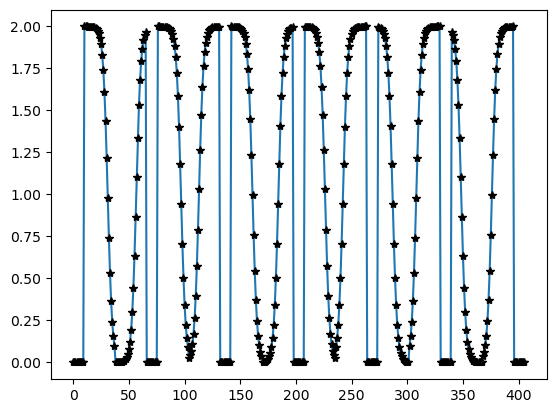

In [31]:
model = ContrastSensitivity(
    parameters=parameters,
    SF_seq=csenf_stim.SF_seq,  
    CON_seq=csenf_stim.CON_seq,   

)
pred = model.predict()
id = 3
plt.plot(pred.iloc[:,id])
plt.plot(eg_ts[id,:], '*k')

# With HRF

/Users/marcusdaghlian/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/Users/marcusdaghlian/programs/dpu_packages/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in divide
  cthresh_values = 100/csenf_values


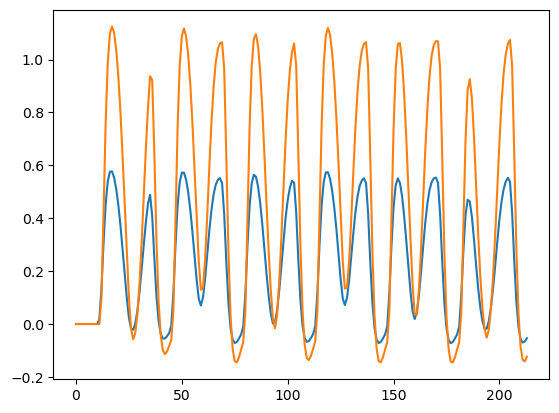

In [9]:
csenf_model = CSenFModel(
    stimulus = csenf_stim,    
    hrf=[1, 1, 0],
    edge_type='CRF',
    normalize_hrf=False,
)

eg_ts = csenf_model.return_prediction(
    width_r     = parameters['width_r'].to_numpy(),
    SFp         = parameters['SFp'].to_numpy(),
    CSp         = parameters['CSp'].to_numpy(),
    width_l     = parameters['width_l'].to_numpy(),
    crf_exp     = parameters['crf_exp'].to_numpy(),
    beta   = parameters['amplitude'].to_numpy(),
    baseline    = parameters['baseline'].to_numpy(),    
)

model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=csenf_stim.SF_seq,  
    CON_seq=csenf_stim.CON_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred.iloc[:,0])
plt.plot(eg_ts[0,:])

[ 0.       0.25     0.38962  0.60722  0.94635  1.4749   2.2986   3.5823
  5.583    8.701   13.56    21.134   32.937   51.332   80.     ]


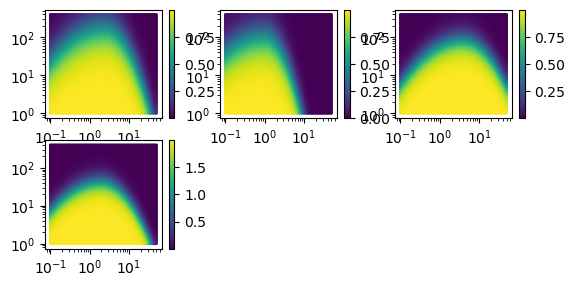

In [10]:
SFs = np.unique(sfs_seq)
CONs = np.unique(con_seq)
print(CONs)
SF_grid     = np.logspace(np.log10(0.1), np.log10(50), 100)
CON_grid    = np.logspace(np.log10(0.25), np.log10(100), 100)
SF_grid, CON_grid = np.meshgrid(SF_grid, CON_grid)
csf, sf, con = model.get_csf_for_plot(SF_grid=SF_grid, CON_grid=CON_grid)
for i in range(4):
    ax = plt.subplot(3, 3, i+1)
    ax.scatter(
        x=sf,
        y=100/con, 
        c=csf[i,:],
        cmap='viridis',
        s=1
    )
    # ax.set_xlim([.1, 50])    
    # ax.set_ylim([.25, 100])
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Add colorbar
    cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    # bloop
    # plt.axis("off")

## Predictions (no noise)

<Axes: >

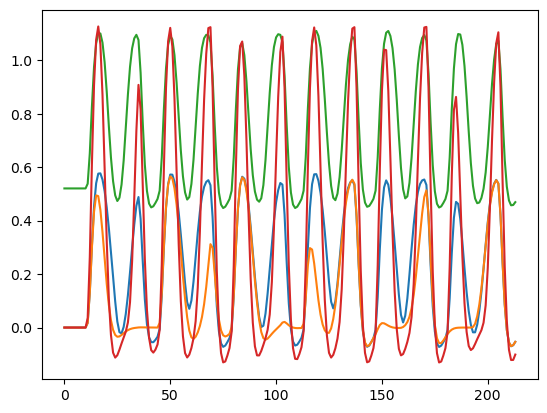

In [11]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

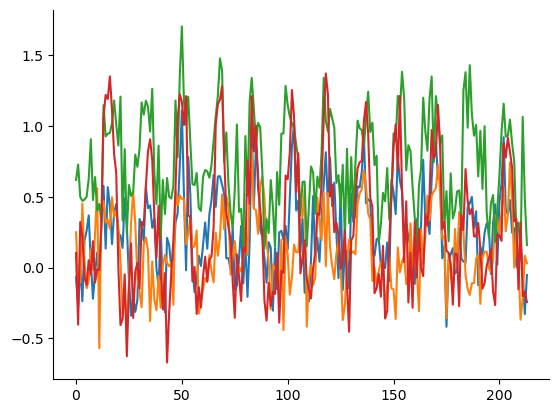

In [12]:
data = model.simulate(noise=.2)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [13]:
from braincoder.optimize import ParameterFitter
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=csenf_stim.SF_seq,  
    CON_seq=csenf_stim.CON_seq,   
    hrf_model=SPMHRFModel(tr=1.5),

)
fitter = ParameterFitter(model, data, model.paradigm)
grid_pars = fitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 3, 10),
    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = fitter.refine_baseline_and_amplitude(grid_pars)
ols_pars

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with chunk size of 778816
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.333333,2.666667,100.000000,0.68,1.444444,0.934836,0.086828
1,1.666667,1.333333,100.000000,0.68,2.777778,0.798413,0.034230
2,0.666667,2.666667,66.666664,0.68,2.333333,1.007272,0.777364
3,1.000000,2.000000,50.000000,0.68,3.000000,1.698922,0.002892


In [14]:
refined_pars = fitter.fit(
    init_pars=ols_pars, 
    learning_rate=0.001, 
    # legacy_adam=True, 
    # optimizer='l-bfgs',
    )
refined_pars

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 4


Current R2: 0.60625/Best R2: 0.60625: 100%|██████████| 1000/1000 [00:04<00:00, 231.77it/s]


parameter,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.443866,3.071282,100.458229,0.579767,1.458476,1.023571,0.073119
1,1.757875,1.486394,98.921844,0.112542,3.282438,0.860510,0.022376
2,0.685760,2.359980,67.063240,0.843741,2.271555,1.107260,0.988969
3,0.896345,1.381405,49.099361,1.203963,3.296244,1.918496,-0.023070


In [15]:
print(parameters)

        width_r  SFp    CSp  width_l  crf_exp  amplitude  baseline
source                                                            
0          1.28  2.5  166.0     0.68      1.5        1.0       0.0
1          1.50  1.0  100.0     0.68      1.5        1.0       0.0
2          1.00  4.0   80.0     0.68      2.5        1.0       1.0
3          1.00  2.0   40.0     0.68      3.0        2.0       0.0


In [ ]:
print(refined_pars)
print(parameters)

In [16]:
r2 = fitter.get_rsq(refined_pars)
r2

source
0    0.531743
1    0.472391
2    0.607009
3    0.813866
Name: r2, dtype: float32

# Slice sampler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target probability density function (unnormalized standard normal)
# def target_distribution(x):
#     a = np.exp(-(x-2)**2 / 2)
#     b = np.exp(-(x+2)**2 / 2)
#     # Normalize 
    
#     # return np.exp(-x**2 / 2)
#     return (a + b)


def target_distribution(x):
    # Bi-modal distribution
    a = np.exp(-(x-2)**2 / 3)
    b = np.exp(-(x+2)**2 / 1)
    return a + b
# Slice sampling function
def slice_sampling(target, x0, num_samples, step_size=1.0):
    """
    Perform slice sampling to generate samples from the target distribution.
    
    Parameters:
    - target: Function representing the target probability density (unnormalized).
    - x0: Initial value of x.
    - num_samples: Number of samples to generate.
    - step_size: Size of the interval for finding the slice.

    Returns:
    - samples: A list of sampled values.
    """
    samples = []  # List to store generated samples
    x = x0        # Initialize the starting point
    
    for _ in range(num_samples):
        # Step 1: Sample u uniformly from (0, target(x))
        u = np.random.uniform(0, target(x))

        # Step 2: Define the slice and find the interval
        # The slice is defined as the interval where target(x) > u
        # Start with an interval of length step_size around x
        left = x - step_size
        right = x + step_size
        
        # Expand the interval until it fully contains the slice
        while target(left) > u:
            left -= step_size
        while target(right) > u:
            right += step_size

        # Step 3: Sample a new x uniformly within the slice
        while True:
            x_new = np.random.uniform(left, right)
            if target(x_new) > u:  # Accept if the new point is in the slice
                x = x_new
                break
        
        # Store the sampled value
        samples.append(x)
    
    return samples

# Parameters
num_samples = 10000   # Number of samples to generate
x0 = 0.0             # Initial value of x
step_size = 1.0      # Step size for finding the slice

# Perform slice sampling
samples = slice_sampling(target_distribution, x0, num_samples, step_size)

# Plot the results
x_vals = np.linspace(-4, 4, 1000)
plt.figure(figsize=(12, 6))

# Plot the target distribution
plt.plot(x_vals, target_distribution(x_vals), label="Target Distribution (Unnormalized)", color="blue")

# Plot histogram of samples
plt.hist(samples, bins=30, density=True, alpha=0.6, color="orange", label="Samples (Histogram)")

plt.title("Slice Sampling - Toy Example")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
samples